### Descripción del Dataset

- **Dataset:** Titanic - Machine Learning from Disaster
- **Descripción:** El clásico dataset para predecir la supervivencia de pasajeros del Titanic.
- **Target:** Survived (0: No sobrevivió, 1: Sobrevivió).
- **Atributos interesantes:**
    - **Categóricos:** Sex, Embarked, Pclass.
    - **Numéricos:** Age, Fare.
    - **Valores nulos:** Age, Cabin, Embarked.
- **Tareas de preprocesamiento:**
    - Imputar valores nulos en Age y Embarked.
    - Convertir atributos categóricos como Sex y Embarked en numéricos.
**Dónde encontrarlo**: [Disponible en Kaggle Titanic Challenge.](https://www.kaggle.com/competitions/titanic/overview) 

# 1. Preparación de los datos

In [1]:
import pandas as pd

# Carga del dataset
df = pd.read_csv('../datasets/train.csv')

# Vista previa de los datos
print(df.head())
# print(df.info())

# Cantidad de registros
# print(len(df))
print(f"Cantidad de registros: {df.shape[0]}")


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Ca

**Análisis inicial**

In [2]:
# Tipos de datos
print(df.dtypes)

# Cantidad de valores nulos por columna
print(df.isnull().sum())

# Cantidad de valores únicos por columna
# print(df['Sex'].value_counts())
# print(df['Survived'].value_counts())

# Estadisticas descriptivas de las columnas numéricas
df.describe()

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Limpieza de datos** 

- Reemplazo de valores nulos en las columnas `Age` y `Embarked`

In [3]:
# Reemplazo de valores nulos en 'Age' con la mediana
df['Age'] = df['Age'].fillna(df['Age'].median())

# Reemplazo de valores nulos en 'Embarked' con la moda
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Comprobar los valores nulos en cada columna
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

**Eliminar columnas no relevantes:** 

- `PassengerId` es un identificador único para cada pasajero, al ser simplemente un índice no aporta mucha informacion util para el modelo.
- La columna `Name` el nombre en sí no tiene una relación directa con la supervivencia.
- `Ticket` tampoco tiene una relación directa con la supervivencia, podria tener relevancia por su relacion con la clase o el precio del ticket, pero debido a que esta información se encuentra recogida en las colunmas `Pclass` y `Fare`, creo que es seguro eliminarla.
- Dado que la columna `Cabin` tiene una gran cantidad de valores nulos, he optado por eliminarla.


In [4]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Comprobar los valores nulos en cada columna
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

**Convertir variables categóricas**

- Convertir `Sex` y `Embarked` en variables numéricas

In [5]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Tipos de datos
print(df.dtypes)

Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object


# 2. Análisis de importancia de propiedades

El objetivo es determinar qué características (columnas) del dataset son más relevantes para predecir la variable objetivo (`Survived` en este caso). 

Para ello he decidido usar el modelo `DecisionTreeClassifier` porque proporciona una medida de la importancia de cada una características del Dataset.

Para ello, necesitamos dividir los datos en dos partes:
- **X (las características):** son las columnas que usaremos para hacer predicciones. Por ejemplo, la edad del pasajero, su género, la clase en la que viajaba, etc. (La colunma `Survived` se elimina en este caso)

- **y (la variable objetivo):** es la columna que queremos predecir. En este caso, es `Survived`, que indica si el pasajero sobrevivió (1) o no (0).  


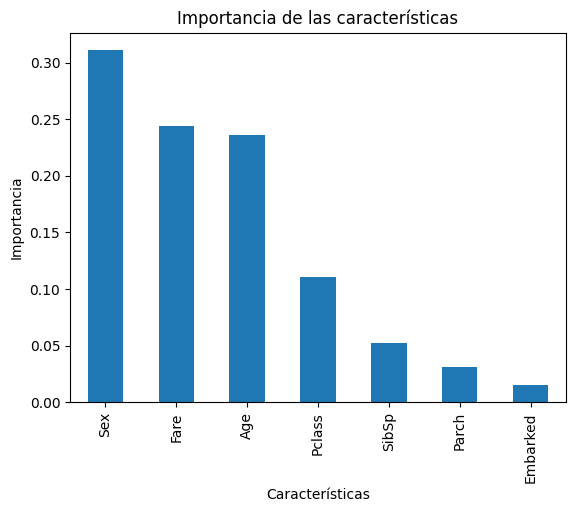

In [6]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Prepararion de los datos
X = df.drop(['Survived'], axis=1)
y = df['Survived']

# Crear y entrenar el modelo
model = DecisionTreeClassifier()
model.fit(X, y)

# Importancia de las características
importances = model.feature_importances_

# Visualización de la importancia de las características
importance_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)
importance_series.plot(kind='bar')
plt.title("Importancia de las características")
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

**Interpretación**
- `Sex`, `Fare` y `Age` son las características más importantes para predecir la supervivencia.
- `Pclass` tiene una importancia moderada.
- `SibSp`, `Parch` y `Embarked` tienen una importancia baja o nula.

# 3. Ingeniería de propiedades

**Escalar los datos de las columnas numéricas**
- Esto se hace porque el algoritmo SVM es sensible a la escala de los datos.
- Si las características tienen escalas muy diferentes, el modelo podría darle más importancia a los valores más grandes, incluso si no son más importantes.

In [7]:
from sklearn.preprocessing import StandardScaler

# Crear un escalador
scaler = StandardScaler()

# Aplicar el escalado a las características (X)
X_scaled = scaler.fit_transform(X)

# Mostrar los datos escalados
print(X_scaled)

[[ 0.82737724 -0.73769513 -0.56573646 ... -0.47367361 -0.50244517
  -0.56883712]
 [-1.56610693  1.35557354  0.66386103 ... -0.47367361  0.78684529
   1.00518113]
 [ 0.82737724  1.35557354 -0.25833709 ... -0.47367361 -0.48885426
  -0.56883712]
 ...
 [ 0.82737724  1.35557354 -0.1046374  ...  2.00893337 -0.17626324
  -0.56883712]
 [-1.56610693 -0.73769513 -0.25833709 ... -0.47367361 -0.04438104
   1.00518113]
 [ 0.82737724 -0.73769513  0.20276197 ... -0.47367361 -0.49237783
   2.57919938]]


# 4. Entrenamiento del modelo

**Modelos**
- Voy a usar dos modelos **SVM** con **GridSearch** y **Árbol de Decisión (DT)** 

**Dividir los datos**

In [8]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Entrenar los modelos**

# REVISAR ESTO

- **SVM** con **GridSearch** para la de optimización de hiperparámetros

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir la cuadrícula de hiperparámetros
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)

# Crear un nuevo modelo SVM con los mejores hiperparámetros
best_svm = SVC(C=grid_search.best_params_['C'], kernel=grid_search.best_params_['kernel'])

# Entrenar el modelo final
best_svm.fit(X_train, y_train)

Mejores parámetros: {'C': 1, 'kernel': 'rbf'}


SVC(C=1)

- **Árbol de Decisión:**

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

# 5. Pruebas

**Realizar las predicciones para cada modelo**

In [22]:
# Predicciones de SVM
y_pred_svm = best_svm.predict(X_test)

# Predicciones de Árbol de Decisión
y_pred_dt = dt_model.predict(X_test)

**Generar la matriz de confusión de cada modelo**
- La matriz de confusión muestra cuántas predicciones fueron correctas e incorrectas:

In [23]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión para SVM
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("Matriz de confusión - SVM:")
print(conf_matrix_svm)

# Matriz de confusión para Árbol de Decisión
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Matriz de confusión - Árbol de Decisión:")
print(conf_matrix_dt)

Matriz de confusión - SVM:
[[94 11]
 [22 52]]
Matriz de confusión - Árbol de Decisión:
[[86 19]
 [18 56]]


**Calcular la precisión (Accuracy)**
- La precisión mide el porcentaje de predicciones correctas sobre el total de predicciones.

In [24]:
from sklearn.metrics import accuracy_score

# Precisión para SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Precisión - SVM: {:.2f}".format(accuracy_svm))

# Precisión para Árbol de Decisión
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Precisión - Árbol de Decisión: {:.2f}".format(accuracy_dt))

Precisión - SVM: 0.82
Precisión - Árbol de Decisión: 0.79


**Visualización de los resultados**

**Gráfico de Barras para la precisión**

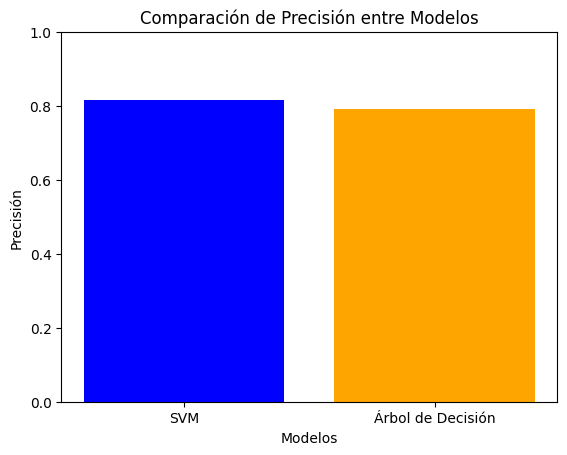

In [25]:
import matplotlib.pyplot as plt

# Datos para el gráfico
models = ['SVM', 'Árbol de Decisión']
accuracy = [accuracy_svm, accuracy_dt]

# Crear el gráfico
plt.bar(models, accuracy, color=['blue', 'orange'])
plt.title('Comparación de Precisión entre Modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.ylim(0, 1)  # Límite del eje y
plt.show()

**Matrices de Confusión**

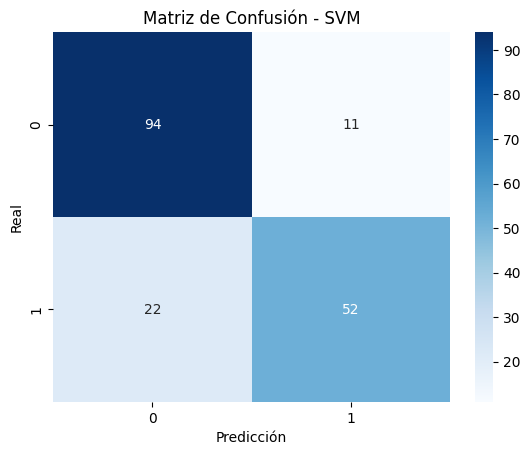

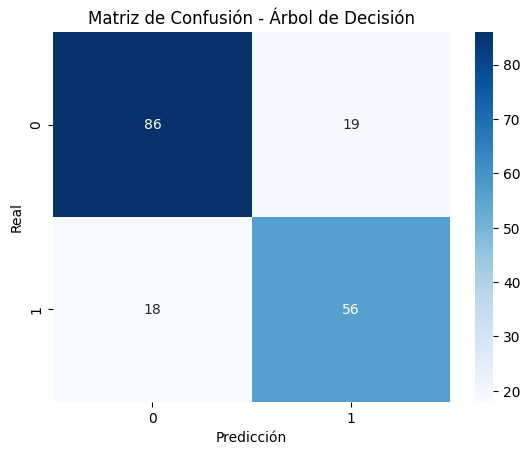

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar las matrices de confusión de forma gráfica
def plot_confusion_matrix(conf_matrix, title):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(conf_matrix_svm, 'Matriz de Confusión - SVM')
plot_confusion_matrix(conf_matrix_dt, 'Matriz de Confusión - Árbol de Decisión')

In [29]:
from sklearn.metrics import classification_report

print("Reporte de clasificación SVM:")
print(classification_report(y_test, y_pred_svm))

print("Reporte de clasificación DT:")
print(classification_report(y_test, y_pred_dt))

Reporte de clasificación SVM:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179

Reporte de clasificación DT:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       105
           1       0.75      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



**Análisis de resultados**

# 6. Serialización del modelo

He usado **joblib** porque **pickle** me daba problemas de compatibilidad con la version de python instalada en mi PC (3.13.1)

In [31]:
# Guardar el modelo entrenado usando joblib:
import joblib

# Guardar los modelos en la carpeta 'models/'
joblib.dump(best_svm, '../models/svm_model.pkl')
joblib.dump(dt_model, '../models/dt_model.pkl')


['../models/dt_model.pkl']